In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the Actor network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Define the Critic network
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value

In [4]:
# Function to select an action based on the state
def select_action(state, actor):
    state = torch.FloatTensor(state).unsqueeze(0)
    action_probs = actor(state)
    action_dist = torch.distributions.Categorical(action_probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action)

In [5]:
# Training function for Actor-Critic
def train(env, actor, critic, actor_optimizer, critic_optimizer, gamma=0.99, max_episodes=1000):
    episode_rewards = []  # List to store episode rewards

    for episode in range(max_episodes):
        state = env.reset()
        episode_reward = 0
        log_probs = []
        values = []
        rewards = []

        done = False
        while not done:
            action, log_prob = select_action(state, actor)
            value = critic(torch.FloatTensor(state).unsqueeze(0))

            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            episode_reward += reward
            state = next_state

        # Compute discounted rewards and advantages
        rewards = torch.FloatTensor(rewards)
        values = torch.cat(values)
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)

        # Calculate advantages
        advantages = returns - values.squeeze()

        # Update Actor network
        actor_loss = (-torch.stack(log_probs) * advantages.detach()).sum()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Update Critic network
        critic_loss = nn.MSELoss()(values.squeeze(), returns)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Store total reward for this episode
        episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1}, Total Reward: {episode_reward}")

    return episode_rewards

In [6]:
# Function to plot episode-wise rewards
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Episode-wise Reward over Training")
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Total Reward: 34.0
Episode 2, Total Reward: 16.0
Episode 3, Total Reward: 16.0
Episode 4, Total Reward: 32.0
Episode 5, Total Reward: 21.0
Episode 6, Total Reward: 37.0
Episode 7, Total Reward: 18.0
Episode 8, Total Reward: 13.0
Episode 9, Total Reward: 16.0
Episode 10, Total Reward: 13.0
Episode 11, Total Reward: 14.0
Episode 12, Total Reward: 15.0
Episode 13, Total Reward: 12.0
Episode 14, Total Reward: 32.0
Episode 15, Total Reward: 11.0
Episode 16, Total Reward: 25.0
Episode 17, Total Reward: 10.0
Episode 18, Total Reward: 16.0
Episode 19, Total Reward: 29.0
Episode 20, Total Reward: 14.0
Episode 21, Total Reward: 23.0
Episode 22, Total Reward: 14.0
Episode 23, Total Reward: 16.0
Episode 24, Total Reward: 10.0
Episode 25, Total Reward: 19.0
Episode 26, Total Reward: 30.0
Episode 27, Total Reward: 34.0
Episode 28, Total Reward: 12.0
Episode 29, Total Reward: 27.0
Episode 30, Total Reward: 13.0
Episode 31, Total Reward: 11.0
Episode 32, Total Reward: 11.0
Episode 33, Total

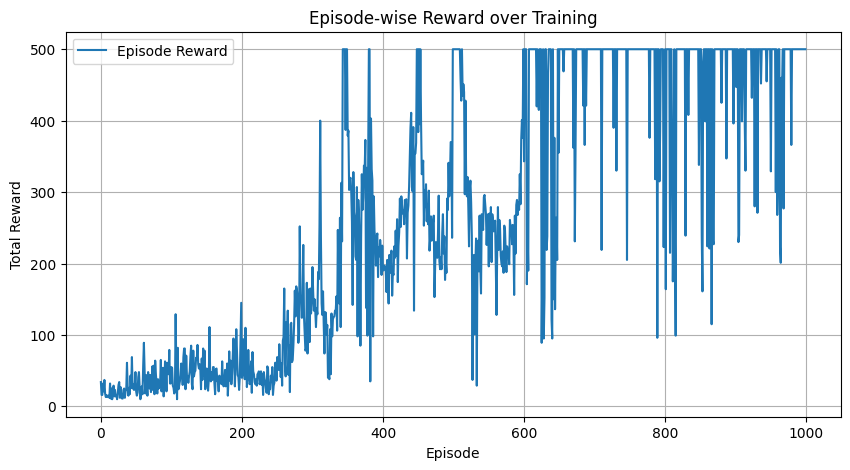

In [7]:
# Main function to run the training and plot results
def main():
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Create Actor and Critic networks
    actor = Actor(state_dim, action_dim)
    critic = Critic(state_dim)

    # Define optimizers
    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
    critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

    # Train the Actor-Critic model and obtain rewards
    episode_rewards = train(env, actor, critic, actor_optimizer, critic_optimizer)

    # Plot the episode-wise rewards
    plot_rewards(episode_rewards)

if __name__ == "__main__":
    main()
